In [ ]:
! ray --version

In [ ]:
import ray
import os

def initialize_ray():
    ray.shutdown()
    
    if ray.is_initialized() == False:
       service_host = os.environ["RAY_HEAD_SERVICE_HOST"]
       service_port = os.environ["RAY_HEAD_SERVICE_PORT"]
       _temp_dir='/domino/datasets/local/{}/'.format(os.environ['DOMINO_PROJECT_NAME']) #set to a dataset
       #ray.util.connect(f"{service_host}:{service_port}")
       address=f"ray://{service_host}:{service_port}"
       ray.init(address=address, _temp_dir=_temp_dir)

In [ ]:
#ray.nodes()

In [ ]:
import ray
import time

#ray.init()
initialize_ray()
no_of_tasks = 200000
sleep_time = 5

@ray.remote
def f(x):
    time.sleep(sleep_time)
    return x + x


futures = [f.remote(i) for i in range(no_of_tasks)]

# Optionally wait for completion
results = ray.get(futures)
print("Done:", results[:no_of_tasks])

## Error message from Domino with the above program

The program hangs with 10000 scheduled and 100000 waiting to be scheduled

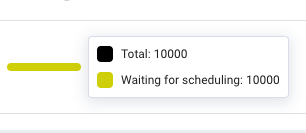
```
/opt/conda/lib/python3.9/site-packages/ray/util/client/worker.py:614: UserWarning: More than 10MB of messages have been created to schedule tasks on the server. This can be slow on Ray Client due to communication overhead over the network. If you're running many fine-grained tasks, consider running them inside a single remote function. See the section on "Too fine-grained tasks" in the Ray Design Patterns document for more details: https://docs.google.com/document/d/167rnnDFIVRhHhK4mznEIemOtj63IOhtIPvSYaPgI4Fg/edit#heading=h.f7ins22n6nyl. If your functions frequently use large objects, consider storing the objects remotely with ray.put. An example of this is shown in the "Closure capture of large / unserializable object" section of the Ray Design Patterns document, available here: https://docs.google.com/document/d/167rnnDFIVRhHhK4mznEIemOtj63IOhtIPvSYaPgI4Fg/edit#heading=h.1afmymq455wu
  warnings.warn(
```


## Anti-pattern - Too many fine grained tasks
```
@ray.remote
def double(number):
    return number * 2

numbers = list(range(10000))

doubled_numbers = []
for i in numbers:
    doubled_numbers.append(ray.get(double.remote(i)))
```

## Fix - Use Batching

```
@ray.remote
def double_list(list_of_numbers):
    return [number * 2 for number in list_of_numbers]

numbers = list(range(10000))
doubled_list_refs = []
BATCH_SIZE = 100
for i in range(0, len(numbers), BATCH_SIZE):
    batch = numbers[i : i + BATCH_SIZE]
    doubled_list_refs.append(double_list.remote(batch))

doubled_numbers = []

for ref in doubled_list_refs:
    doubled_numbers.extend(ray.get(ref))
```

### What is happening

1. Ray Client Bottleneck
You're likely using Ray Client (ray.init(address="...")), not local Ray.

Ray Client streams task metadata over the network, and this line:
```
UserWarning: More than 10MB of messages have been created to schedule tasks on the server...
indicates you're overwhelming that control channel.
This isn’t a memory issue, it’s a control-plane throughput problem over the Ray Client protocol.
```

2. Global Scheduling Queue Saturation
The dashboard shows:

10,000 scheduled, 10,000 waiting

This means:

10,000 tasks have been scheduled onto workers

10,000 more are waiting in the GCS scheduler

The rest are still in submission or backpressured inside the client driver

3. **Task Flooding and Internal Limits**
Ray has several hard limits:

- `max_in_flight_requests`: limits how many pending submissions the client can buffer.

- `max_calls_in_flight_per_worker`: limits how many calls per worker can be open.

- Network gRPC queue sizes.

**These limits exist to protect the system from task flood.**

4. **Unbatched, Fine-Grained Tasks**
Each f.remote(i) schedules a task with:

Small payload (an int)

High overhead (sleeping 5s, holding up a worker)

No batching

This results in:

- Poor system utilization

- Backlogged queue

- High scheduler load

- Control channel congestion

5. **No Ray.get() or Ray.wait() Control**
You're firing off 200,000 tasks and calling ray.get() only after. This creates a massive unbounded queue.



```
from tqdm import tqdm
results = []
batch_size = 1000
for i in tqdm(range(0, no_of_tasks, batch_size)):
    futures = [f.remote(j) for j in range(i, i + batch_size)]
    results.extend(ray.get(futures))
```

### Fix Option A: Batch Submission
Throttle and reuse:

In [ ]:
from tqdm import tqdm
initialize_ray()
results = []
batch_size = 1000
for i in tqdm(range(0, no_of_tasks, batch_size)):
    futures = [f.remote(j) for j in range(i, i + batch_size)]
    results.extend(ray.get(futures))

### Fix Option B: Use ray.wait()
This code submits 200,000 Ray tasks while keeping at most 1,000 tasks in-flight at a time, using ray.wait() to manage backpressure and avoid overwhelming the system.


In [ ]:
import ray
import time
initialize_ray()
sleep_time = 0.01
@ray.remote
def f(x):
    time.sleep(sleep_time)
    return x + x

# Specifies that 200,000 tasks should be run, but only 1,000 should be active (submitted but not completed) at a time.
no_of_tasks = 200000
max_in_flight = 1000

'''
Next line submits the first 1,000 tasks immediately.
These are stored in pending as ObjectRefs.
'''
pending = [f.remote(i) for i in range(max_in_flight)]

#Initializes the results list to collect outputs.
results = []

# This for loop starts with i=1000 and ends with i=199999
# It takes one task from pending and r
for i in range(max_in_flight, no_of_tasks):
    # ray.wait(pending, num_returns=1) waits for one task in pending to finish.
    done, pending = ray.wait(pending, num_returns=1)
    # done has 1 completed ref.
    # pending now has 999 remaining (those still in-flight).
    
    # retrieves its result and adds it to results
    results.extend(ray.get(done))
    #f.remote(i) submits the next task and adds it to pending.
    pending.append(f.remote(i))

results.extend(ray.get(pending))
# print("Done:", results[:5])
print("Done:", results[:5])


/opt/conda/lib/python3.9/site-packages/ray/util/client/worker.py:614: UserWarning: More than 10MB of messages have been created to schedule tasks on the server. This can be slow on Ray Client due to communication overhead over the network. If you're running many fine-grained tasks, consider running them inside a single remote function. See the section on "Too fine-grained tasks" in the Ray Design Patterns document for more details: https://docs.google.com/document/d/167rnnDFIVRhHhK4mznEIemOtj63IOhtIPvSYaPgI4Fg/edit#heading=h.f7ins22n6nyl. If your functions frequently use large objects, consider storing the objects remotely with ray.put. An example of this is shown in the "Closure capture of large / unserializable object" section of the Ray Design Patterns document, available here: https://docs.google.com/document/d/167rnnDFIVRhHhK4mznEIemOtj63IOhtIPvSYaPgI4Fg/edit#heading=h.1afmymq455wu
  warnings.warn(


### Summary
- Ray Client can't handle huge bulk submissions. It was not designed for this.

- The dashboard reflects accurate queue state: you’re hitting system and network limits.

- Switch to batching or throttled task submission, or restructure to use fewer long-lived tasks or actors.

| Goal                         | Achieved by                                      |
|:-----------------------------|:-------------------------------------------------|
| Avoid overwhelming Ray       | Max 1,000 concurrent tasks using `ray.wait`      |
| Backpressure handling        | `ray.wait(..., num_returns=1)`                   |
| Controlled memory usage      | Bounded `pending` list                           |
| Complete execution           | Final `ray.get(pending)`                         |


In [ ]:
'''
#Try this out to understand how i looks like
no_of_tasks = 200000
max_in_flight = 1000
for i in range(max_in_flight, no_of_tasks):
    print(i)
'''    